# Packages

In [127]:
using Pkg; Pkg.activate("."); #Pkg.add("DelimitedFiles")
using MUST
using PyPlot
using LaTeXStrings
using DelimitedFiles
using TSO

MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2"       # Importing dispatch in general and set the paths
MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2" EOS   # Importing the dispatch EOS python for the legacy EoS
MUST.@get_help visual; 

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/EoS/Project.toml`


# EoS Table

In [128]:
## 4 Bins legacy EoS directly from DISPATCH
leEos = MUST.@legacyPythonEOS ;

In [129]:
## Also import them in the TSO interface to check for errors
path = MUST.@in_dispatch("input_data/DIS_MARCS_v0.1.1")
eos_direct = TSO.reload(TSO.SqEoS, joinpath(path, "eos.hdf5"))
opa_direct = TSO.reload(TSO.SqOpacity, joinpath(path, "binned_opacities.hdf5"));

In [130]:
path  = abspath.("stagger_av.dat")
model = reverse(readdlm(path, skipstart=2), dims=1)
z_profile, T_profile, d_profile = model[:, 1], model[:, 2], exp.(model[:, 3]);

In [131]:
limits(eos_direct)

(28.058182f0, 30.623783f0, -49.76333f0, -3.9202807f0)

# New EoS Grid

In [132]:
units = MUST.StaggerCGS();

In [133]:
leEos.eos.__dict__

Dict{Any, Any} with 11 entries:
  "tables"    => Dict{Any, Any}(5=>Dict{Any, Any}(5=>PyObject <dispatch.EOS.irr…
  "info"      => Dict{Any, Any}("units"=>"code", "ul"=>1.0e8, "ut"=>100.0, "mbo…
  "variables" => Dict{Any, Any}(5=>"T", 8=>"S2", 1=>"K1", 0=>"P", 6=>"", 9=>"S3…
  "scales"    => Dict{Any, Any}(5=>PyObject <dispatch.EOS.irregular_tables.inde…
  "nv"        => 11
  "index"     => PyObject <bound method independent_c.index of <dispatch.EOS.ir…
  "scale0"    => PyObject <dispatch.EOS.irregular_tables.independent_c object a…
  "scale1"    => PyObject <dispatch.EOS.irregular_tables.independent_c object a…
  "gamma"     => 1.4
  "file"      => "data/eos/stagger/table.dat"
  "type"      => "stagger-E"

In [134]:
leEos.eos.scale0.__dict__

Dict{Any, Any} with 7 entries:
  "name"   => "ln(rho)"
  "step"   => 0.513461
  "max"    => 6.31419
  "min"    => -25.5204
  "values" => [-25.5204, -25.0069, -24.4935, -23.98, -23.4666, -22.9531, -22.43…
  "offset" => 0
  "n"      => 63

In [135]:
d0 = Float32(minimum(leEos.eos.scale0.values)) + log(units.d)
d1 = Float32(maximum(leEos.eos.scale0.values)) + log(units.d)
dr = Float32(d1 - d0)
d  = range(Float32(d0 +0.01*dr), Float32(d1-0.01*dr), length=length(leEos.eos.scale0.values)) |> collect

63-element Vector{Float32}:
 -41.320152
 -40.81696
 -40.313766
 -39.810577
 -39.307384
 -38.80419
 -38.301
 -37.79781
 -37.294617
 -36.791424
   ⋮
 -14.147785
 -13.644593
 -13.141401
 -12.638209
 -12.135017
 -11.631825
 -11.1286335
 -10.625442
 -10.12225

In [136]:
e0 = log(Float32(minimum(leEos.eos.scale1.values)) * units.ee)
e1 = log(Float32(maximum(leEos.eos.scale1.values)) * units.ee)
er = Float32(e1 - e0)
e  = range(Float32(e0 +0.01*er), Float32(e1-0.01*er), length=length(leEos.eos.scale1.values)) |> collect

908-element Vector{Float32}:
 28.887627
 28.889788
 28.891949
 28.89411
 28.896269
 28.89843
 28.90059
 28.902752
 28.904913
 28.907074
  ⋮
 30.83011
 30.832272
 30.834433
 30.836594
 30.838755
 30.840914
 30.843075
 30.845236
 30.847397

We lookup the new grid in the old EoS.

In [137]:
pg = zeros(eltype(d), length(e), length(d))
te = zeros(eltype(d), length(e), length(d))
k  = zeros(eltype(d), length(e), length(d), 4)
s  = zeros(eltype(d), length(e), length(d), 4)

ee = exp.(e) ./ units.ee #.- log(units.ee)
dd = exp.(d) ./ units.d

@show size(ee) size(dd)

look_or_nan(eos, what, d, e, unit=1) = begin
    try
        first(MUST.lookup(eos, what,    d,  e) .*unit)
    catch
        NaN
    end
end

for i in eachindex(d)
    di = dd[i:i]
    for j in eachindex(e)
        pg[j, i]   = look_or_nan(leEos, :P,    di,  ee[j:j], units.p)
        te[j, i]   = look_or_nan(leEos, :T,    di,  ee[j:j], 1)
        k[j, i, 1] = look_or_nan(leEos, :K1,   di,  ee[j:j], units.rk)
        k[j, i, 2] = look_or_nan(leEos, :K2,   di,  ee[j:j], units.rk)
        k[j, i, 3] = look_or_nan(leEos, :K3,   di,  ee[j:j], units.rk)
        k[j, i, 4] = look_or_nan(leEos, :K4,   di,  ee[j:j], units.rk)
        s[j, i, 1] = look_or_nan(leEos, :S1,   di,  ee[j:j], units.m ./ units.t^3)
        s[j, i, 2] = look_or_nan(leEos, :S2,   di,  ee[j:j], units.m ./ units.t^3)
        s[j, i, 3] = look_or_nan(leEos, :S3,   di,  ee[j:j], units.m ./ units.t^3)
        s[j, i, 4] = look_or_nan(leEos, :S4,   di,  ee[j:j], units.m ./ units.t^3)
    end
end

size(ee) = (908,)
size(dd) = (63,)


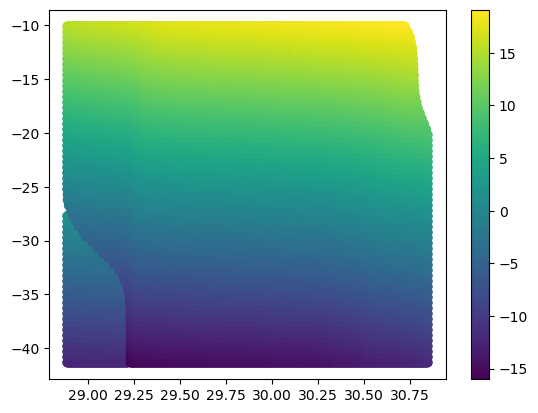

In [138]:
close()

ee, dd = meshgrid(e, d)
plt.scatter(ee, dd, c=log.(pg))
plt.colorbar()

gcf()

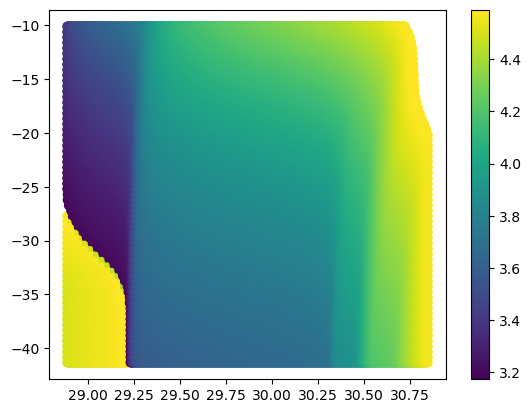

In [139]:
close()

ee, dd = meshgrid(e, d)
plt.scatter(ee, dd, c=log10.(te))
plt.colorbar()

gcf()

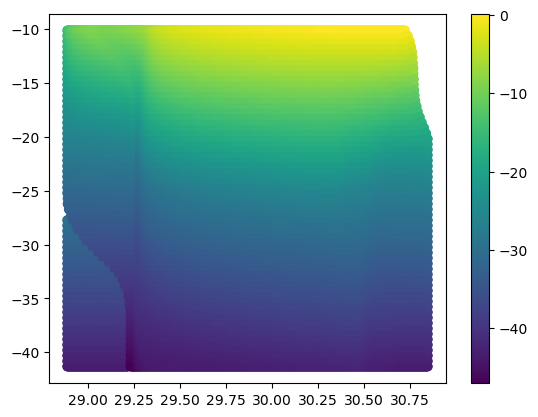

In [140]:
close()

ee, dd = meshgrid(e, d)
plt.scatter(ee, dd, c=log.(k[:, :, 1]))
plt.colorbar()

gcf()

# Save in the internal format TS

In [141]:
eos = SqEoS(deepcopy(d), 
            deepcopy(log.(te)), 
            deepcopy(e), 
            deepcopy(log.(pg)), 
            zeros(eltype(pg), size(pg)...), 
            zeros(eltype(pg), size(pg)...));

In [142]:
opa = SqOpacity(deepcopy(k), 
                zeros(eltype(k), size(k)[1:end-1]...), 
                deepcopy(s),
                Float32.([1., 2., 3., 4.]), 
                false);

# Fill NaN

In [143]:
TSO.fill_nan!(@axed(eos), opa)
#TSO.set_limits!(@axed(eos), opa, small=1e-30, large=1e30)

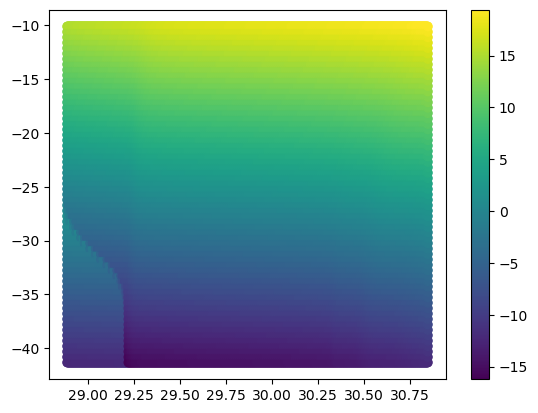

In [144]:
close()

ee, dd = meshgrid(@axed(eos))
plt.scatter(ee, dd, c=eos.lnPg)
plt.colorbar()

gcf()

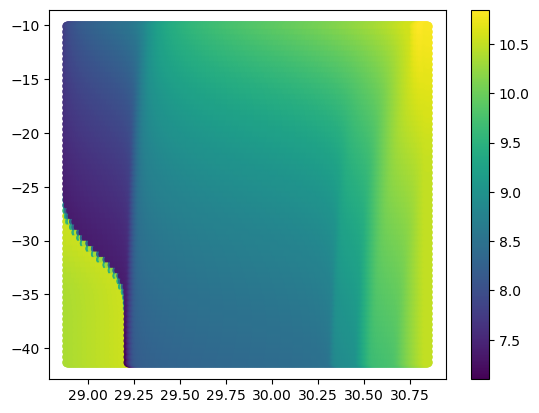

In [145]:
close()

ee, dd = meshgrid(@axed(eos))
plt.scatter(ee, dd, c=eos.lnT)
plt.colorbar()

gcf()

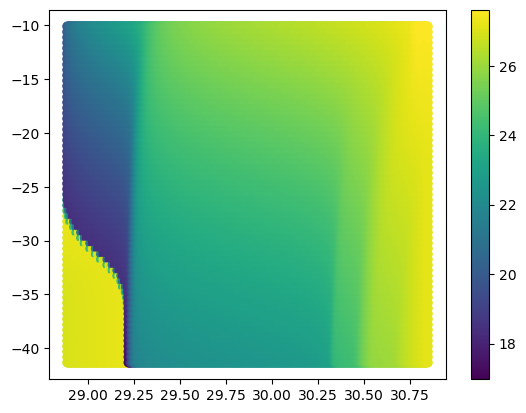

In [146]:
close()

ee, dd = meshgrid(@axed(eos))
plt.scatter(ee, dd, c=log.(opa.src[:, :, 1]))
plt.colorbar()

gcf()

In [147]:
for_dispatch(@axed(eos), TSO.BinnedOpacities(opa))

In [148]:
folder = "DISSTAG_v0.1"
!isdir(folder) && mkdir(folder)

mv("rhoei_radtab.dat", joinpath(folder, "rhoei_radtab.dat"), force=true)
mv("eostable.dat", joinpath(folder, "eostable.dat"), force=true)
mv("tabparam.in", joinpath(folder, "tabparam.in"), force=true)


save(eos, joinpath(folder, "eos.hdf5"))
save(opa, joinpath(folder, "binned_opacities.hdf5"))

"DISSTAG_v0.1/binned_opacities.hdf5"